# Review Sentiment Classification using Bi-LSTMs

In this notebook, we will classify Amazon product reviews as either positive or negative using a [Bidirectional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) [Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (Bi-LSTM) model and pretrained Glove embeddings. The dataset is taken from the following paper:

Ding, X., Liu, B. and Yu, P. S. (2008) ‘A Holistic Lexicon-Based Approach to Opinion Mining’. In *Proceedings of the 2008 International Conference on Web Search and Data Mining (WSDM '08)*. [DOI: 10.1145/1341531.1341561](https://dl.acm.org/doi/10.1145/1341531.1341561).

The the dataset and the corresponding `Readme` is provided in this repository.

## 1. Embeddings and Libraries

The pretrained Glove embeddings can be downloaded from the [Stanford NLP Group's website](https://nlp.stanford.edu/projects/glove/). We will be utilizing the smallest version trained on Wikipedia 2014 and Gigaword 5. To download and extract these embeddings directly within this notebook, run the following cell.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2023-06-07 20:25:12--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-07 20:25:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.05MB/s    in 2m 42s  

2023-06-07 20:27:55 (5.08 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
 

Tensorflow and keras will be used to build the model, while the text will be preprocessed with re and PyTorch's tokenizer:

In [ ]:
import os
import shutil
import re
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding, Bidirectional
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
import torchtext
tokenizer = torchtext.data.get_tokenizer("basic_english")

## 2. Text Preprocessing and Dataset Construction

Here, a series of operations to clean, preprocess, and structure the dataset is carried out. We start with raw .txt files, containing product reviews interspersed with miscellaneous markers that are irrelevant for our sentiment analysis task. Our end goal is to construct a feature matrix 'X' with individual reviews' text content and a corresponding label vector 'Y', signifying the sentiment of each review as determined by the original authors (either positive, marked as 1, or negative, marked as 0).

First, we download the dataset from the repo.

In [ ]:
!git clone https://github.com/patrikasvanagas/Bidirectional-LSTM-Sentiment-Classification.git
shutil.move('Bidirectional-LSTM-Sentiment-Classification/product_reviews', 'product_reviews')
shutil.rmtree('Bidirectional-LSTM-Sentiment-Classification')

Cloning into 'Bidirectional-LSTM-Sentiment-Classification'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), 284.13 KiB | 7.48 MiB/s, done.


Preprocessing involves the removal of superfluous markers, expansion of contractions (which is crucial because these contracted forms often carry substantial semantic load), and the identification of sentiments embedded in the text.

The contraction map is from [Dipanjan Sarkar's repo](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py).

In [ ]:
DATASET_PATH = "./product_reviews/"

# Dataset specific markers are not necessary for sentiment analysis
UNNEEDED_DATASET_MARKERS = [
    "[u]",
    "[p]",
    "[s]",
    "[cc]",
    "[cs]",
]

CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

# re.compile object to help to find document places with contractions
CONTRACTIONS_PATTERN = re.compile(
    "({})".format("|".join(CONTRACTION_MAP.keys())),
    flags=re.IGNORECASE | re.DOTALL,
)


def read_files(folder_path: str) -> str:
    """
    Reads all .txt files in the provided folder and concatenates their content into one string.

    Args:
    folder_path: The path of the folder that contains the .txt files.

    Returns:
    The content of all .txt files in one string.
    """
    text = ""
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder_path, file_name), encoding="utf-8") as file:
                text += file.read()
    return text


def clean_text(text: str, markers: List[str]) -> str:
    """
    Cleans the provided text by removing the specified markers and replacing newline characters with a space.

    Args:
    text: The string to be cleaned.
    markers: A list of string markers to be removed from the text.

    Returns:
    The cleaned text.
    """
    for marker in markers:
        text = text.replace(marker, "")
    text = text.replace("\n", " ").replace("##", "## ")
    return text


def expand_contractions(text: str) -> str:
    """
    Expand all contractions in a given string.
    Variable names are explanatory.

    text, str: string to expand contractions in

    Returns:
    expanded_text, str: text with expanded contractions
    and removed apostrophess
    """

    def expand_match(contraction):
        """
        Expand a matched contraction.
        Variable names are explanatory.

        contraction, re.Match object: matched contraction in an str

        Returns:
        expanded_text, str: match with expanded contractions
        """
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = (
            CONTRACTION_MAP.get(match)
            if CONTRACTION_MAP.get(match)
            else CONTRACTION_MAP.get(match.lower())
        )
        return first_char + expanded_contraction[1:]

    expanded_text = CONTRACTIONS_PATTERN.sub(expand_match, text)
    expanded_text = re.sub("'", " ", expanded_text)
    return expanded_text


def split_reviews(text: str) -> Tuple[List[str], List[str]]:
    """
    Splits the provided text into separate reviews.

    Args:
    text: The text to be split into separate reviews.

    Returns:
    A tuple of two lists: the split text and the rated reviews.
    """
    rated_reviews_cluster_list = [
        split_by_t_element
        for split_by_t_element in list(filter(None, text.split("[t]")))
        if "]##" in split_by_t_element
    ]
    return rated_reviews_cluster_list


def replace_token_with_sentiment(token):
    """
    Replaces a token with a sentiment marker string if it contains a sentiment marker, removes it if it is a review marker or "##", and keeps it unchanged otherwise.

    Args:
    token: The token to be checked and possibly replaced or removed.

    Returns:
    The replaced token if it contained a sentiment marker, None if it was a review marker or "##", and the original token otherwise.
    """
    if "]##" in token:
        rating, _ = token.split("##")
        return (
            "positivesentimentfollows" if "+" in rating else "negativesentimentfollows"
        )
    elif "[+" in token or "[-" in token or token == "##":
        return None
    else:
        return token


def tokenize_and_clean_text(text_range):
    """
    Cleans and tokenizes a range of text.

    Args:
    text_range: The range of text to be cleaned and tokenized.

    Returns:
    The cleaned and tokenized text.
    """
    text = " ".join(text_range)
    cleaned_text = re.sub(r"[^a-zA-z\s]", " ", text)  # remove all non alphabetic tokens
    tokenized_text = " ".join(tokenizer(cleaned_text))
    return tokenized_text


# Read .txt files, expand contractions, and clean the text
huge_string = read_files(DATASET_PATH)
huge_string = expand_contractions(huge_string)
huge_string = clean_text(huge_string, UNNEEDED_DATASET_MARKERS)

# Split the cleaned text into separate reviews
rated_reviews_cluster_list = split_reviews(huge_string)
rated_reviews_cluster_string = "".join(rated_reviews_cluster_list)

# Tokenize the rated reviews.
all_tokens = tokenizer(rated_reviews_cluster_string)

# Identify indices where sentiment markers start and merge the sentiment starts which have another marker before them.
sentiment_start_indices = [
    idx for idx, token in enumerate(all_tokens) if "]##" in token
]

# Create a list of indices where two sentiment markers are next to each other
double_sentiment_start_indices = np.array(
    [idx - 1 for idx in sentiment_start_indices if "]##" in all_tokens[idx - 1]]
)

# In the case of two adjacent positive sentiment markers, remove the first one, 
# as it doesn't alter the interpretation. This is based on the dataset observation 
# that only two positive aspects are mentioned consecutively.
all_tokens = [
    token if idx not in double_sentiment_start_indices else token + all_tokens[idx + 1]
    for idx, token in enumerate(all_tokens)
    if idx not in double_sentiment_start_indices or idx == len(all_tokens) - 1
]

# Replace the sentiment markers in the tokens with "positivesentimentfollows"
# and "negativesentimentfollows", remove the "##" token, and delete the review markers
all_tokens = [
    replace_token_with_sentiment(token)
    for token in all_tokens
    if replace_token_with_sentiment(token) is not None
]
all_tokens = np.array(all_tokens, dtype=np.str_)  # dtype for TF

# Find indices where positive and negative sentiments start
positive_start_indices = np.where(all_tokens == "positivesentimentfollows")
negative_start_indices = np.where(all_tokens == "negativesentimentfollows")

# Add the index of the last token to the list of sentiment start indices
all_start_indices = np.sort(
    np.concatenate(
        (
            positive_start_indices[0],
            negative_start_indices[0],
            np.array([len(all_tokens)]),
        )
    )
)

positive_reviews = []
negative_reviews = []

# Iterate through each sentiment start index
for idx in range(len(all_start_indices) - 1):
    # Extract the review text between the current and the next sentiment start index
    review_text = tokenize_and_clean_text(
        all_tokens[all_start_indices[idx] + 1 : all_start_indices[idx + 1]]
    )
    # Check if the review is positive or negative and add it to the corresponding list
    if all_start_indices[idx] in positive_start_indices[0]:  # positive
        positive_reviews.append(review_text)
    elif all_start_indices[idx] in negative_start_indices[0]:  # negative
        negative_reviews.append(review_text)
# Create the X and Y for the model, with positive reviews being labeled 1 and negative reviews 0.
X_full = np.append(positive_reviews, negative_reviews)
Y_full = np.append(
    np.ones(len(positive_reviews), dtype=np.int8),
    np.zeros(len(negative_reviews), dtype=np.int8),
)


The dataset can shortened to contain reviews no longer than LENGTH_THRESHOLD tokens and equalized so there is an equal number of positive and negative examples (the original dataset features almost twice as many positive reviews as negative ones). 

The dataset can be downloaded as a .csv file. For in-line inspection within this notebook, press the 'magic wand' icon when viewing the dataframe.

In [ ]:
def remove_long_sequences(x, y, length_threshold):
    """
    Remove sequences longer than length_threshold
    number of tokens from the dataset.

    x, np.array - array of strings to be
    classified
    y, np.array - corresponding labels
    length_threshold, int - sequences with
    tokens more than that are removed

    Returns:
    x, np.array - corresponding array of strings
    y, np.array - corresponding array of labels
    """
    short_indices = np.array(
        [idx for idx, entry in enumerate(x) if len(tokenizer(entry)) < length_threshold]
    )
    return x[short_indices], y[short_indices]


def balance_dataset(x, y):
    """
    Randomly equalize the number of positive
    and negative examples for an unbalanced dataset
    (# positives > # negatives)

    x, np.array - array of strings to be
    classified
    y, np.array - corresponding labels

    Returns:
    x, np.array - corresponding array of strings
    y, np.array - corresponding array of labels
    """
    num_negatives = len(np.where(y == 0)[0])
    negative_indices = np.where(y == 0)[0]
    positive_indices = np.where(y == 1)[0]
    random_positive_pick_indices = np.random.choice(
        positive_indices, size=num_negatives, replace=False
    )
    x = np.append(x[random_positive_pick_indices], x[negative_indices])
    y = np.append(y[random_positive_pick_indices], y[negative_indices])
    return x, y

LENGTH_THRESHOLD = 100
BALANCE_DATASET = True

X, Y = X_full, Y_full
if LENGTH_THRESHOLD: X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
if BALANCE_DATASET: X, Y = balance_dataset(X,Y)

df = pd.DataFrame()

df['X'] = X
df['Y'] = Y
df.to_csv('/content/dataset.csv')

# Uncomment the lines below to download the csv file for inspection
# from google.colab import files
# files.download('dataset.csv') #download as csv for inspection

df

,X,Y
0,other than that i think it is the best router ...,1
1,the photo quality is amazing,1
2,itunes can be downloaded from the enclosed cd ...,1
3,i have set up it is pda features with avantgo ...,1
4,bags are easy to change pop the lid fold it ba...,1
...,...,...
1021,there were many times when i clicked the autom...,0
1022,the controls are hard to manipulate especially...,0
1023,the lcd screen is too small since there are so...,0
1024,so so customer service calls half were efficie...,0


## 4. Model and Embedding Utilities

This set of functions provides utilities for handling word embeddings and constructing a binary classification model based on Bi-directional Long Short-Term Memory (Bi-LSTM) networks. These utilities form the foundation of our sentiment analysis model. 

The Glove utilities are closely related to those in the assignments in Week 2 of the Sequence Models course in the Deep Learning Specialization by Deeplearning.ai.

In [ ]:
def read_glove_vecs(glove_file_path):
    """
    Read GloVe embeddings file and generate dictionaries for word to index mapping,
    index to word mapping, and word to vector mapping.

    Parameters:
    glove_file_path (str): Path to the GloVe embeddings file.

    Returns:
    words_to_index (dict): Maps words to their corresponding indices in the vocabulary.
    index_to_words (dict): Maps indices to their corresponding words in the vocabulary.
    word_to_vec_map (dict): Maps words to their GloVe vector representation.
    """
    with open(glove_file_path, "r") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def softmax(x):
    """Compute softmax values for each sets of scores in x vector."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def convert_to_one_hot(Y, C):
    """Convert label vector Y to one-hot representation for C classes."""
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


def sentences_to_indices(X, word_to_index, max_len):
    """
    Convert an array of sentences into an array of word indices.

    Parameters:
    X (np.ndarray): Array of sentences.
    word_to_index (dict): Dictionary mapping words to indices.
    max_len (int): Maximum sentence length.

    Returns:
    X_indices (np.ndarray): Array of word indices.
    """
    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    for i in range(m):  # loop over training examples
        # Convert the ith training sentence in lower case and split is into words, get a list
        sentence_words = X[i].lower().split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        doubles = 0
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                try:  #
                    X_indices[i, j] = word_to_index[w]
                    j = j + 1
                except IndexError:
                    doubles += 1
    return X_indices


def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Create a Keras Embedding layer loaded with pre-trained GloVe vectors.

    Parameters:
    word_to_vec_map (dict): Dictionary mapping words to their GloVe vector representation.
    word_to_index (dict): Dictionary mapping words to indices in the vocabulary.

    Returns:
    embedding_layer (Embedding): Pretrained Keras Embedding layer instance.
    """
    vocab_size = len(word_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[
        0
    ]  # define dimensionality of GloVe word vectors
    # Initialize the embedding matrix as a numpy array of zeros
    emb_matrix = np.zeros((vocab_size, emb_dim))
    # Set each row "idx" of the embedding matrix to be
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(
        input_dim=vocab_size, output_dim=emb_dim, trainable=False
    )
    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,))
    # Set the weights of the embedding layer to the embedding matrix, it's now pretrained
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer
    

def create_model(
    input_shape,
    word_to_vec_map,
    word_to_index,
    lstm_units=128,
    dropout_rate=0.5,
    output_units=2,
):
    """
    Create a binary LSTM model graph.

    Parameters:
    input_shape (tuple): Shape of the input (usually (max_len,)).
    word_to_vec_map (dict): Dictionary mapping words to their GloVe vector representation.
    word_to_index (dict): Dictionary mapping words to indices in the vocabulary.
    lstm_units (int, optional): Number of units in LSTM layers. Defaults to 128.
    dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.5.
    output_units (int, optional): Number of units in the output Dense layer. Defaults to 2.

    Returns:
    model (Model): Keras model instance.
    """
    sentence_indices = Input(shape=input_shape, dtype="int32")
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    X = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embeddings)
    X = Dropout(rate=dropout_rate)(X)
    X = Bidirectional(LSTM(units=lstm_units, return_sequences=False))(X)
    X = Dropout(rate=dropout_rate)(X)
    X = Dense(units=output_units)(X)
    X = Activation("softmax")(X)
    return Model(inputs=sentence_indices, outputs=X)


We can pick the dimensionality of the Glove vectors used (50, 100, 200, and 300 are provided) - the higher the dimensionality, the more information is captured about the word, but at the cost of computational complexity. This should load up in under a minute.

In [ ]:
GLOVE_DIMENSIONALITY = 300

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(
    "/content/glove.6B." + str(GLOVE_DIMENSIONALITY) + "d.txt"
)

# Find the length of the longest sequence in the training set
maxLen = len(max(X, key=len).split())
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("Input_dim", embedding_layer.input_dim)
print("Output_dim", embedding_layer.output_dim)

model = create_model(
    input_shape=(maxLen,),
    word_to_vec_map=word_to_vec_map,
    word_to_index=word_to_index,
    lstm_units=128,
    output_units=2,
)
model.summary()


Input_dim 400001
Output_dim 300
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 98, 300)           120000300 
                                                                 
 bidirectional (Bidirectiona  (None, 98, 256)          439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 98, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         

## 5. Experiments

This part of the notebook sets up the hyperparameters, training configuration and initiates the model training. During the training process, the model learns to predict the class of the text based on the training examples given. Progress and performance metrics are displayed for each epoch.

Early stopping is a form of regularization used to prevent overfitting. In this code, if there's no improvement in validation loss after `PATIENCE` epochs, the training process will halt, thereby avoiding unnecessary computations and potential overfitting. The model weights from the epoch with the best observed validation loss are later restored.

In [ ]:
# Set threshold for sequence length. Sequences with fewer tokens will be included
LENGTH_THRESHOLD = 9999

# Flag to decide if the dataset needs to be balanced (equal number of training and testing examples)
BALANCE_DATASET = True

# Fraction of the dataset used for validation
VAL_SIZE = 0.2

# Number of LSTM units to be used in the model
LSTM_UNITS = 256

# Set number of training epochs
EPOCHS = 9999
# Set learning rate for the optimizer
LR = 10e-5
# Batch size for model training
BATCH_SIZE = 128
# Define early stopping patience. Training halts after this many epochs if the validation loss has not improved
PATIENCE = 18

# Create dataset
X, Y = X_full, Y_full

# Remove sequences longer than LENGTH_THRESHOLD if flag is set
if LENGTH_THRESHOLD:
    X, Y = remove_long_sequences(X, Y, LENGTH_THRESHOLD)
# Balance the dataset if flag is set
if BALANCE_DATASET:
    X, Y = balance_dataset(X, Y)
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=VAL_SIZE)

# Find the length of the longest sequence in the training set
maxLen = len(max(X_train, key=len).split())

# Convert sentences to indexed representation
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
# Convert output labels to one-hot encoding
Y_train_oh = convert_to_one_hot(Y_train, C=2)
Y_test_oh = convert_to_one_hot(Y_test, C=2)

# Define the optimizer
opt = Adam(learning_rate=LR)
# Create the model
model = create_model(
    input_shape=(maxLen,),
    word_to_vec_map=word_to_vec_map,
    word_to_index=word_to_index,
    lstm_units=LSTM_UNITS,
    output_units=2,
)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Define early stopping criteria. Training stops if validation loss doesn't improve after PATIENCE epochs
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=PATIENCE,
    restore_best_weights=True,
)

# Train the model with early stopping
history = model.fit(
    X_train_indices,
    Y_train_oh,
    validation_data=(X_test_indices, Y_test_oh),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[es],
    verbose=1,
)


Epoch 1/9999
7/7 [==============================] - 17s 1s/step - loss: 0.6955 - accuracy: 0.4771 - val_loss: 0.6876 - val_accuracy: 0.5138
Epoch 2/9999
7/7 [==============================] - 5s 739ms/step - loss: 0.6854 - accuracy: 0.5872 - val_loss: 0.6815 - val_accuracy: 0.6330
Epoch 3/9999
7/7 [==============================] - 5s 686ms/step - loss: 0.6774 - accuracy: 0.6250 - val_loss: 0.6734 - val_accuracy: 0.6514
Epoch 4/9999
7/7 [==============================] - 5s 685ms/step - loss: 0.6665 - accuracy: 0.6640 - val_loss: 0.6632 - val_accuracy: 0.6468
Epoch 5/9999
7/7 [==============================] - 5s 710ms/step - loss: 0.6500 - accuracy: 0.6835 - val_loss: 0.6470 - val_accuracy: 0.6743
Epoch 6/9999
7/7 [==============================] - 5s 680ms/step - loss: 0.6212 - accuracy: 0.6984 - val_loss: 0.6227 - val_accuracy: 0.6514
Epoch 7/9999
7/7 [==============================] - 5s 743ms/step - loss: 0.5780 - accuracy: 0.7202 - val_loss: 0.5993 - val_accuracy: 0.7064
Epoch 8/

We plot two key metrics across epochs:

1. **Loss vs Epoch**: The red 'X' mark indicates the point of minimum validation loss.
2. **Accuracy vs Epoch**: The red 'X' mark indicates the epoch where we achieved the highest validation accuracy, and the blue 'X' mark shows the epoch where early stopping occurred due to minimum validation loss

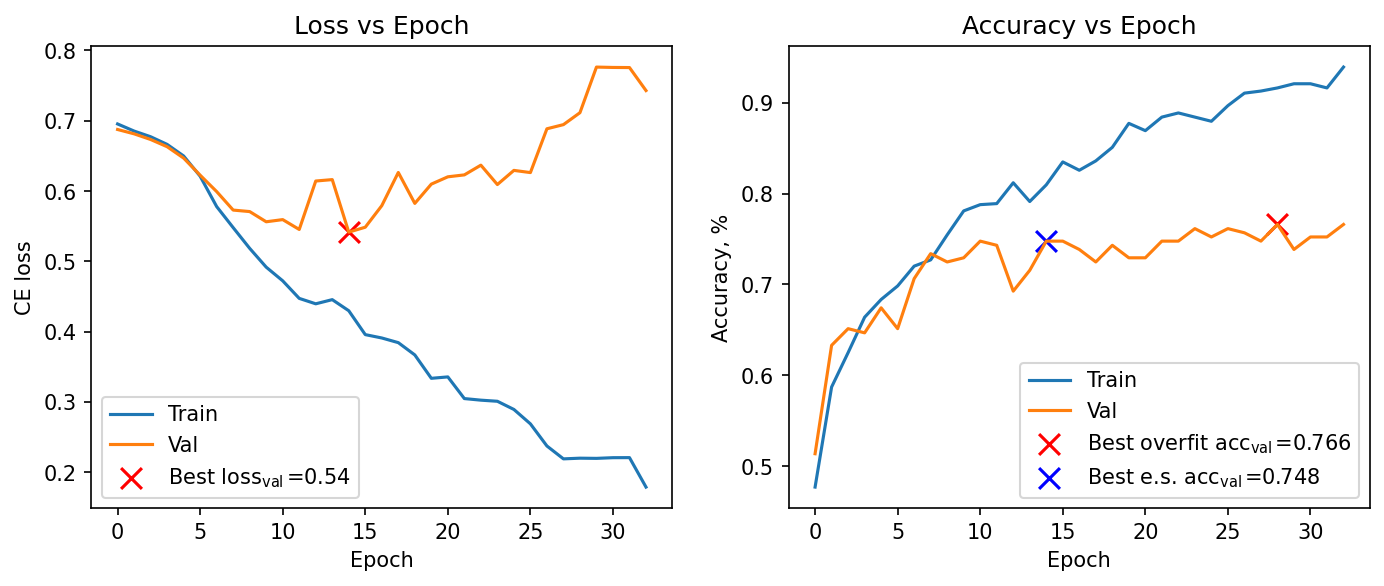

In [ ]:
fig = plt.figure(figsize=(11, 4), dpi=150)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history["loss"], label="Train")
ax1.plot(history.history["val_loss"], label="Val")
ax1.scatter(
    np.arange(0, len(history.history["val_loss"]))[
        np.argmin(history.history["val_loss"])
    ],
    np.min(history.history["val_loss"]),
    marker="x",
    label=r"Best $\operatorname{loss}_{\operatorname{val}}}$=" + str(np.round(np.min(history.history["val_loss"]), 2)),
    c="r",
    s=100,
    alpha=1,
)
ax1.set_title("Loss vs Epoch")
ax1.set_xlabel(r"Epoch")
ax1.legend(loc="best")
ax1.set_ylabel("CE loss")
ax2.plot(history.history["accuracy"], label="Train")
ax2.plot(history.history["val_accuracy"], label="Val")
ax2.scatter(
    np.arange(0, len(history.history["val_accuracy"]))[
        np.argmax(history.history["val_accuracy"])
    ],
    np.max(history.history["val_accuracy"]),
    marker="x",
    label=r"Best overfit $\operatorname{acc}_{\operatorname{val}}}$="
    + str(np.round(np.max(history.history["val_accuracy"]), 3)),
    c="r",
    s=100,
    alpha=1,
)
ax2.scatter(
    np.arange(0, len(history.history["val_accuracy"]))[
        np.argmin(history.history["val_loss"])
    ],
    (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])],
    marker="x",
    label=r"Best e.s. $\operatorname{acc}_{\operatorname{val}}}$="
    + str(
        np.round(
            (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])], 3
        )
    ),
    c="b",
    s=100,
    alpha=1,
)
ax2.set_title("Accuracy vs Epoch")
ax2.set_xlabel(r"Epoch")
ax2.legend(loc="best")
ax2.set_ylabel("Accuracy, %")

plt.legend()
plt.show()

Now that the model has been trained, we can explore its performance in predicting the sentiment of some test sentences. The first element of the output is the probability of a negative sentiment, while the second one is the probability of the positive sentiment.

In [ ]:
# Define sentences
sentence1 = "This gadget is great" #positive
sentence2 = "does not turn on" #negative
sentence3 = "thistokenisdefinitelynotpartofthevocabulary andneitheristhisone" #not in the dictionary

# Predict and print sentiments
print(model.predict(sentences_to_indices(np.array([sentence1]), word_to_index, maxLen)))
print(model.predict(sentences_to_indices(np.array([sentence2]), word_to_index, maxLen)))
print(model.predict(sentences_to_indices(np.array([sentence3]), word_to_index, maxLen)))


1/1 [==============================] - 1s 1s/step
[[0.0543902  0.94560987]]
1/1 [==============================] - 0s 55ms/step
[[0.82433456 0.17566551]]
1/1 [==============================] - 0s 57ms/step
[[0.47425362 0.5257464 ]]


Additionally, we can carry out experiments with, say, 3-fold cross validation. Here, let's compare the results when equalizing the number of positive and negative examples and vice versa. If the number of positive examples is much larger, the model would be incentivised to bias its predictions towards the positive class.

For this, we define `run_kfold_cv_experiment`:

In [ ]:
def run_kfold_cv_experiment(
    X_full,
    Y_full,
    dataset_balanced,
    n_splits=3,
    length_threshold=9999,
    val_size=0.2,
    lstm_units=128,
    epochs=9999,
    lr=10e-5,
    batch_size=256,
    patience=10,
):
    """
    Performs k-fold cross-validation on the given dataset using a LSTM model and returns the best accuracies.

    Parameters:
    X_full (numpy array): The full set of input data.
    Y_full (numpy array): The full set of target data.
    dataset_balanced (bool): Whether to balance the dataset or not.
    n_splits (int): The number of folds for cross-validation.
    length_threshold (int): Maximum sequence length. Sequences longer than this will be removed.
    val_size (float): The size of the validation set as a percentage of the total dataset.
    lstm_units (int): The number of units in the LSTM layer.
    epochs (int): The number of epochs to train for.
    lr (float): The learning rate for the Adam optimizer.
    batch_size (int): The batch size for training.
    patience (int): The patience for early stopping.

    Returns:
    best_early_stopping_accuracies (list): List of best accuracies achieved with early stopping for each fold.
    best_overfit_accuracies (list): List of best accuracies achieved with overfitting for each fold.
    """

    best_early_stopping_accuracies = []
    best_overfit_accuracies = []

    X, Y = X_full, Y_full
    if length_threshold:
        X, Y = remove_long_sequences(X, Y, length_threshold)
    if dataset_balanced:
        X, Y = balance_dataset(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=val_size)

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((Y_train, Y_test), axis=0)

    kfold = KFold(n_splits=n_splits, shuffle=True)
    opt = Adam(learning_rate=lr)
    es = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=1,
        patience=patience,
        restore_best_weights=True,
    )

    for counter, data in tqdm(enumerate(kfold.split(inputs, targets))):
        print(
            "\n######## Training and evaluation in split ",
            str(counter + 1),
            " ########\n",
        )
        train, test = data
        X_train, X_test, Y_train, Y_test = (
            inputs[train],
            inputs[test],
            targets[train],
            targets[test],
        )
        maxLen = len(max(X_train, key=len).split())

        X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
        X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
        Y_train_oh = convert_to_one_hot(Y_train, C=2)
        Y_test_oh = convert_to_one_hot(Y_test, C=2)

        model = create_model(
            input_shape=(maxLen,),
            word_to_vec_map=word_to_vec_map,
            word_to_index=word_to_index,
            lstm_units=lstm_units,
            output_units=2,
        )
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

        history = model.fit(
            X_train_indices,
            Y_train_oh,
            validation_data=(X_test_indices, Y_test_oh),
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            callbacks=[es],
            verbose=2,
        )

        best_early_stopping_accuracies.append(
            (history.history["val_accuracy"])[np.argmin(history.history["val_loss"])]
        )
        best_overfit_accuracies.append(np.max(history.history["val_accuracy"]))

        print("\n")
    print("\n\n##################### RESULTS #####################")
    print(
        "With overfitting the train set, the accuracy is ",
        str(np.round((np.mean(best_overfit_accuracies)), 3)),
        "±",
        str(np.round(np.std(best_overfit_accuracies), 3)),
    )
    print(
        "With early stopping, the accuracy is ",
        str(np.round((np.mean(best_early_stopping_accuracies)), 3)),
        "±",
        str(np.round(np.std(best_early_stopping_accuracies), 3)),
    )

    return best_early_stopping_accuracies, best_overfit_accuracies


First, with balancing:

In [ ]:
run_kfold_cv_experiment(X_full, Y_full, dataset_balanced=True)

0it [00:00, ?it/s]


######## Training and evaluation in split  1  ########

Epoch 1/9999
3/3 - 10s - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6889 - val_accuracy: 0.5632 - 10s/epoch - 3s/step
Epoch 2/9999
3/3 - 2s - loss: 0.6884 - accuracy: 0.5592 - val_loss: 0.6870 - val_accuracy: 0.5714 - 2s/epoch - 640ms/step
Epoch 3/9999
3/3 - 2s - loss: 0.6876 - accuracy: 0.5620 - val_loss: 0.6852 - val_accuracy: 0.5797 - 2s/epoch - 640ms/step
Epoch 4/9999
3/3 - 2s - loss: 0.6870 - accuracy: 0.5702 - val_loss: 0.6832 - val_accuracy: 0.5907 - 2s/epoch - 667ms/step
Epoch 5/9999
3/3 - 4s - loss: 0.6838 - accuracy: 0.5978 - val_loss: 0.6811 - val_accuracy: 0.6044 - 4s/epoch - 1s/step
Epoch 6/9999
3/3 - 2s - loss: 0.6832 - accuracy: 0.5771 - val_loss: 0.6786 - val_accuracy: 0.6099 - 2s/epoch - 683ms/step
Epoch 7/9999
3/3 - 2s - loss: 0.6804 - accuracy: 0.6212 - val_loss: 0.6758 - val_accuracy: 0.6291 - 2s/epoch - 617ms/step
Epoch 8/9999
3/3 - 2s - loss: 0.6792 - accuracy: 0.6061 - val_loss: 0.6728 - val_accuracy: 0.

([0.7554945349693298, 0.71074378490448, 0.702479362487793],
 [0.7692307829856873, 0.7382920384407043, 0.7245178818702698])

Now, without balancing:

In [ ]:
run_kfold_cv_experiment(X_full, Y_full, dataset_balanced=False)

0it [00:00, ?it/s]


######## Training and evaluation in split  1  ########

Epoch 1/9999
4/4 - 10s - loss: 0.6907 - accuracy: 0.5567 - val_loss: 0.6791 - val_accuracy: 0.6255 - 10s/epoch - 2s/step
Epoch 2/9999
4/4 - 2s - loss: 0.6753 - accuracy: 0.6134 - val_loss: 0.6702 - val_accuracy: 0.6317 - 2s/epoch - 467ms/step
Epoch 3/9999
4/4 - 2s - loss: 0.6727 - accuracy: 0.6237 - val_loss: 0.6653 - val_accuracy: 0.6317 - 2s/epoch - 445ms/step
Epoch 4/9999
4/4 - 2s - loss: 0.6669 - accuracy: 0.6227 - val_loss: 0.6624 - val_accuracy: 0.6317 - 2s/epoch - 465ms/step
Epoch 5/9999
4/4 - 2s - loss: 0.6623 - accuracy: 0.6227 - val_loss: 0.6603 - val_accuracy: 0.6317 - 2s/epoch - 499ms/step
Epoch 6/9999
4/4 - 2s - loss: 0.6635 - accuracy: 0.6227 - val_loss: 0.6579 - val_accuracy: 0.6317 - 2s/epoch - 493ms/step
Epoch 7/9999
4/4 - 2s - loss: 0.6577 - accuracy: 0.6227 - val_loss: 0.6547 - val_accuracy: 0.6317 - 2s/epoch - 469ms/step
Epoch 8/9999
4/4 - 2s - loss: 0.6549 - accuracy: 0.6227 - val_loss: 0.6513 - val_accuracy:

([0.7695473432540894, 0.7154639363288879, 0.7092783451080322],
 [0.7798354029655457, 0.7216494679450989, 0.7216494679450989])